## Group-5 Capstone Project Notebook

## Importing necessary Tools and Tool sets

In [1]:
import sqlite3 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import FuncFormatter
%matplotlib inline

def millions_formatter(x, pos):
    return f'{x / 100000000}'


## Establishing a connection to the SQL Database

In [2]:
conn = sqlite3.connect('data/zippedData/im.db')

## Connecting and opening the Movie Budget Data
-We chose this data because it provided insight into the Production budgets as well as the gross domestic revenue and the total worldwide revenue. 
-This dataset also have the name of the movies, this allows us to join this data set with the IMDB dataset

In [3]:
movie_budget = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Pulling the Data we want to work with from SQL Database

In [4]:
imbd = pd.read_sql("""
SELECT DISTINCT mb.primary_title, mb.genres,  p.primary_name as director
FROM movie_basics as mb,
directors as d on d.movie_id = mb.movie_id,
persons as p on d.person_id = p.person_id
; """, conn)
imbd

,primary_title,genres,director
0,Sunghursh,"Action,Crime,Drama",Harnam Singh Rawail
1,One Day Before the Rainy Season,"Biography,Drama",Mani Kaul
2,The Other Side of the Wind,Drama,Orson Welles
3,Sabse Bada Sukh,"Comedy,Drama",Hrishikesh Mukherjee
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy",Raoul Ruiz
...,...,...,...
163103,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary,Ana Célia de Oliveira
163104,Dankyavar Danka,Comedy,Kanchan Nayak
163105,6 Gunn,None,Kiran Gawade
163106,Chico Albuquerque - Revelações,Documentary,Vinicius Augusto Bozzo


## Testing out Joins 
-This cell joins the movie_budget table with the SQL data pulled from above and create a new table "joins" 
-This new table shows the production budget, domestic gross, and world wide gross values of the movies from the movie_budget table along with the genres and directors of the movies
-This join is done by using an inner join connecting the tables using the title of the movies 

In [5]:
joins = movie_budget.set_index('movie').join(imbd.set_index('primary_title'), how='inner')
joins.reset_index(inplace=True)
joins.groupby('id').first()
joins

,index,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director
0,#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,"Crime,Drama,Horror",Tara Subkoff
1,10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422","Drama,Horror,Mystery",Dan Trachtenberg
2,10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",Drama,Timothy Hines
3,12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648","Action,Drama,Romance",Gabriel Soriano
4,12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378","Action,Drama,History",Nicolai Fuglsig
...,...,...,...,...,...,...,...,...
4162,Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616","Adventure,Animation,Comedy",Byron Howard
4163,Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616","Adventure,Animation,Comedy",Rich Moore
4164,Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616","Adventure,Animation,Comedy",Jared Bush
4165,Zulu,82,"Dec 31, 2013","$16,000,000",$0,"$1,844,228","Crime,Drama,Thriller",Jérôme Salle


## Getting rid of Duplicate data
-Because some movies in our data set had multiple directors attributed to the movie we were getting duplicated movie indexes. 
-With the concentrated time we had for this data we decided to take only the first listed director for the movies. This allows us to work with the data in the production budget, domestic gross and worldwide gross values. 

In [6]:
joins = joins.groupby('index').nth(0)

## Chooses only the first genre
-Because multiple movies have multiple genres it was difficult to make distinctions of the data based on genre. With the concentrated time we had to work on this project we decided to take only the first genre listed in the genre column, this may affect the data

In [7]:
joins['genres'] = joins['genres'].str.split(",")
joins['genres'] = joins['genres'].fillna('Unknown')
for x in range(joins['genres'].count()):
    if joins['genres'][x] == 'Unknown':
        joins['genres'][x] = 'Unknown'
    else:
        joins['genres'][x] = joins['genres'][x][0]
        x +=1
joins

<ipython-input-7-608fd6d50ce4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joins['genres'][x] = joins['genres'][x][0]
<ipython-input-7-608fd6d50ce4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joins['genres'][x] = 'Unknown'


,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director
index,,,,,,,
#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,Crime,Tara Subkoff
10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422",Drama,Dan Trachtenberg
10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",Drama,Timothy Hines
12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648",Action,Gabriel Soriano
12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378",Action,Nicolai Fuglsig
...,...,...,...,...,...,...,...
Zoolander 2,64,"Feb 12, 2016","$50,000,000","$28,848,693","$55,348,693",Comedy,Ben Stiller
Zoom,26,"Aug 11, 2006","$35,000,000","$11,989,328","$12,506,188",Animation,Pedro Morelli
Zootopia,57,"Mar 4, 2016","$150,000,000","$341,268,248","$1,019,429,616",Adventure,Byron Howard


## Cleaning the data
-Turning the money string values into integers 

In [8]:
joins['domestic_gross']= joins['domestic_gross'].str.replace(',','')
joins['domestic_gross']= joins['domestic_gross'].str.replace('$','')
joins['domestic_gross'] = pd.to_numeric(joins['domestic_gross'])
joins['worldwide_gross']= joins['worldwide_gross'].str.replace(',','')
joins['worldwide_gross']= joins['worldwide_gross'].str.replace('$','')
joins['worldwide_gross'] = pd.to_numeric(joins['worldwide_gross'])
joins['production_budget']= joins['production_budget'].str.replace(',','')
joins['production_budget']= joins['production_budget'].str.replace('$','')
joins['production_budget'] = pd.to_numeric(joins['production_budget'])

## Creating a Profit column 

In [9]:
joins['profit'] = joins['worldwide_gross'] - joins['production_budget']
joins = joins.sort_values('profit', ascending=False)
joins.at['Avatar','director'] = 'James Cameron'
joins.at['Titanic','director'] = 'James Cameron'

joins

,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director,profit
index,,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,Horror,James Cameron,2351345279
Titanic,43,"Dec 19, 1997",200000000,659363944,2208208395,Adventure,James Cameron,2008208395
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,Action,Anthony Russo,1748134200
Jurassic World,34,"Jun 12, 2015",215000000,652270625,1648854864,Action,Colin Trevorrow,1433854864
Furious 7,67,"Apr 3, 2015",190000000,353007020,1518722794,Action,James Wan,1328722794
...,...,...,...,...,...,...,...,...
Call of the Wild,36,"Feb 21, 2020",82000000,0,0,Adventure,Chris Sanders,-82000000
Bright,80,"Dec 13, 2017",90000000,0,0,Action,David Ayer,-90000000
Men in Black: International,42,"Jun 14, 2019",110000000,3100000,3100000,Action,F. Gary Gray,-106900000


## Data Analysis for Directors 

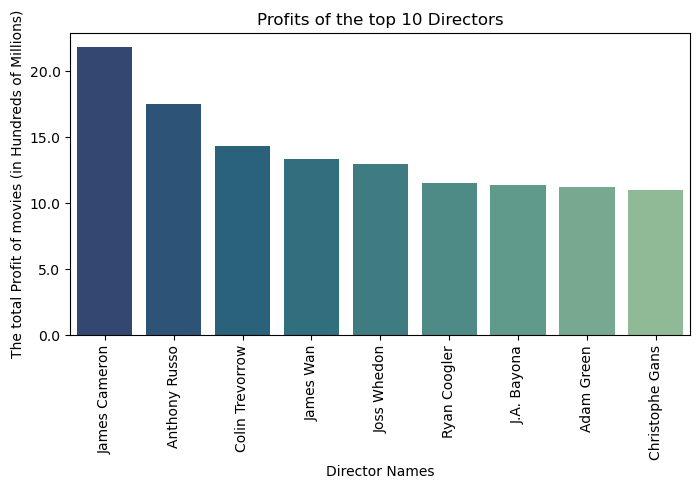

In [10]:
from matplotlib.pyplot import figure
#We want to search through only the top 10% of the data
percentage = int(round((len(joins['director'])/10),0))

x_axis = joins['director'].head(10)
y_axis = joins['profit'].head(10) 

figure(figsize=(8, 4), dpi=100)

ax = sns.barplot(x=x_axis, y=y_axis, ci=None, color='blue', palette='crest_r')


plt.xticks(rotation=90)
plt.title('Profits of the top 10 Directors')
plt.xlabel('Director Names')
plt.ylabel('The total Profit of movies (in Hundreds of Millions)')
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))


## Creating a copy of the joined dataset 


In [11]:
copy = joins 
movies = []
n = len(copy)

for x in range(n):
    movies.append(copy.index[x])
movies
#Adding in a movies column so that we are able to search for the movie name within the dataset
copy['movies'] = movies

copy

,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director,profit,movies
index,,,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,Horror,James Cameron,2351345279,Avatar
Titanic,43,"Dec 19, 1997",200000000,659363944,2208208395,Adventure,James Cameron,2008208395,Titanic
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,Action,Anthony Russo,1748134200,Avengers: Infinity War
Jurassic World,34,"Jun 12, 2015",215000000,652270625,1648854864,Action,Colin Trevorrow,1433854864,Jurassic World
Furious 7,67,"Apr 3, 2015",190000000,353007020,1518722794,Action,James Wan,1328722794,Furious 7
...,...,...,...,...,...,...,...,...,...
Call of the Wild,36,"Feb 21, 2020",82000000,0,0,Adventure,Chris Sanders,-82000000,Call of the Wild
Bright,80,"Dec 13, 2017",90000000,0,0,Action,David Ayer,-90000000,Bright
Men in Black: International,42,"Jun 14, 2019",110000000,3100000,3100000,Action,F. Gary Gray,-106900000,Men in Black: International


## Choosing the top 10% of the directors 

In [12]:
top50_dir = copy['director'].value_counts().head(percentage)
top50_dir = top50_dir.index

## Finding all of the movies that were directed by the top 10% of directors and then finding their profit 

In [13]:
top50_dir_movies = copy.loc[copy['director'].isin(top50_dir), 'profit']
top50_dir_profit = top50_dir_movies.values
type(top50_dir_profit)

numpy.ndarray

## Creating a Normally Distributed graph of the Profits of the top 10% of directors

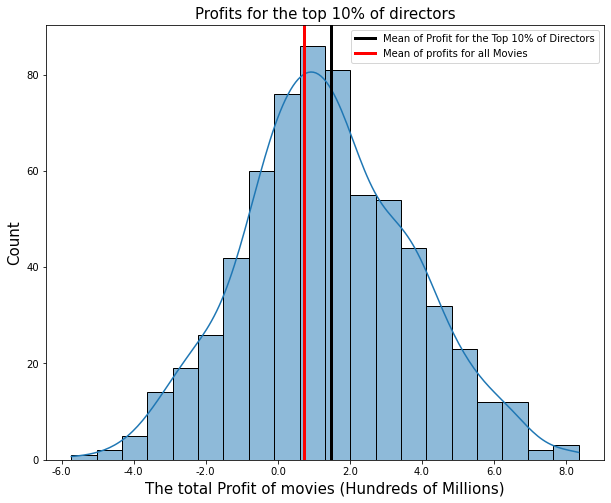

In [14]:
top50_dir_profit_mean = top50_dir_profit.mean() 
top50_dir_profit_std = top50_dir_profit.std()
top50_dir_profit_n = len(top50_dir_profit)
top50_dir_profit_median = np.median(top50_dir_profit)

fig, ax = plt.subplots(figsize=(10, 8))

s1  = np.random.normal(top50_dir_profit_mean,top50_dir_profit_std, top50_dir_profit_n)

sns.histplot(s1, kde=True, palette='crest_r')


ax.set_title('Profits for the top 10% of directors', fontdict={'fontsize': 15})
ax.set_xlabel('The total Profit of movies (Hundreds of Millions)', fontdict={'fontsize': 15})
ax.set_ylabel('Count', fontdict={'fontsize': 15})
ax.axvline(top50_dir_profit_mean, color='k', linewidth=3, label='Mean of Profit for the Top 10% of Directors')
ax.axvline(joins['profit'].mean(), color='r', linewidth=3, label='Mean of profits for all Movies')
ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax.legend()

## The central Tendenancys of the Profits of the top 10% of Directors

In [15]:
print(f"The average profits for movies directed by the top 10% of Directors is: {round(top50_dir_profit_mean,2)} dollars")
print(f"The median profits for movies directed by the top 10% of Directors is: {top50_dir_profit_median} dollars")
print(f"The standard deviation of the Profits for movies directed by the top 10% of Directors is: {round(top50_dir_profit_std,2)} dollars")
print(f"The mean of the Profits for all of the movies : {round(joins['profit'].mean(),2)}")
print(f"The movies directed by the top 10% of directors out performed the profits of all the movied by {round((top50_dir_profit_mean - joins['profit'].mean()),2)} dollars")

The average profits for movies directed by the top 10% of Directors is: 146552227.2 dollars
The median profits for movies directed by the top 10% of Directors is: 56249176.0 dollars
The standard deviation of the Profits for movies directed by the top 10% of Directors is: 233797496.04 dollars
The mean of the Profits for all of the movies : 72947804.24
The movies directed by the top 10% of directors out performed the profits of all the movied by 73604422.96 dollars


# Limiting the data to the top 25% of Production Budget 

We took the median of the production budget and only in cluded what was greater than it here it was 18000000

In [16]:
limiter = joins.copy()
limiter['production_budget'].median()
limiter_test = limiter.loc[limiter['production_budget'] >= 18000000]
limiter_test

,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director,profit,movies
index,,,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,Horror,James Cameron,2351345279,Avatar
Titanic,43,"Dec 19, 1997",200000000,659363944,2208208395,Adventure,James Cameron,2008208395,Titanic
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,Action,Anthony Russo,1748134200,Avengers: Infinity War
Jurassic World,34,"Jun 12, 2015",215000000,652270625,1648854864,Action,Colin Trevorrow,1433854864,Jurassic World
Furious 7,67,"Apr 3, 2015",190000000,353007020,1518722794,Action,James Wan,1328722794,Furious 7
...,...,...,...,...,...,...,...,...,...
Call of the Wild,36,"Feb 21, 2020",82000000,0,0,Adventure,Chris Sanders,-82000000,Call of the Wild
Bright,80,"Dec 13, 2017",90000000,0,0,Action,David Ayer,-90000000,Bright
Men in Black: International,42,"Jun 14, 2019",110000000,3100000,3100000,Action,F. Gary Gray,-106900000,Men in Black: International


We then took the median of the limited data again to net the top 25% which was 42000000

In [17]:
limiter_test['production_budget'].median()
limiter_test2 = limiter_test.loc[limiter_test['production_budget'] >= 42000000]
limiter_test2

,id,release_date,production_budget,domestic_gross,worldwide_gross,genres,director,profit,movies
index,,,,,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279,Horror,James Cameron,2351345279,Avatar
Titanic,43,"Dec 19, 1997",200000000,659363944,2208208395,Adventure,James Cameron,2008208395,Titanic
Avengers: Infinity War,7,"Apr 27, 2018",300000000,678815482,2048134200,Action,Anthony Russo,1748134200,Avengers: Infinity War
Jurassic World,34,"Jun 12, 2015",215000000,652270625,1648854864,Action,Colin Trevorrow,1433854864,Jurassic World
Furious 7,67,"Apr 3, 2015",190000000,353007020,1518722794,Action,James Wan,1328722794,Furious 7
...,...,...,...,...,...,...,...,...,...
Call of the Wild,36,"Feb 21, 2020",82000000,0,0,Adventure,Chris Sanders,-82000000,Call of the Wild
Bright,80,"Dec 13, 2017",90000000,0,0,Action,David Ayer,-90000000,Bright
Men in Black: International,42,"Jun 14, 2019",110000000,3100000,3100000,Action,F. Gary Gray,-106900000,Men in Black: International


# Creating the data visualizaiton of the Produciton Budget and Profit in hundreds of million in USD

C:\Users\ztillery\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


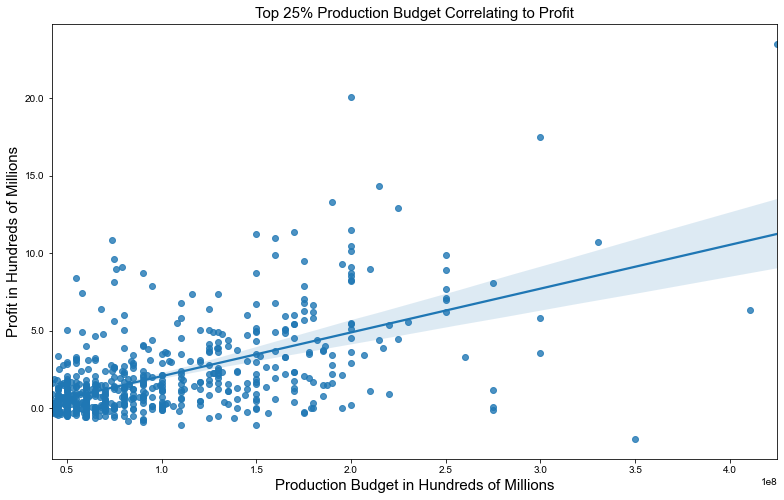

In [18]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.regplot(limiter_test2['production_budget'], limiter_test2['profit'])
plt.title('Top 25% Production Budget Correlating to Profit', fontdict={'fontsize': 15})
plt.xlabel('Production Budget in Hundreds of Millions', fontdict={'fontsize': 15})
plt.ylabel('Profit in Hundreds of Millions', fontdict={'fontsize': 15})
sns.set_theme(palette = 'crest_r')
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Data Analysis for Genres

First we need to analyze the total number of genres from our generated DataFrame using value_counts() to get an understanding of the relative distribution.

In [19]:
joins['genres'].value_counts()

Action         539
Drama          494
Comedy         415
Adventure      200
Biography      149
Horror         137
Documentary    129
Crime          120
Thriller        31
Animation       21
Unknown         12
Sci-Fi           9
Fantasy          8
Family           7
Mystery          7
Romance          5
Music            4
Musical          4
War              3
Sport            2
Western          2
Name: genres, dtype: int64

We can now create a new DataFrame by copying 'joins' where we only grab the necessary categories for visualization purposes.

In [20]:
g_vis = joins[(['genres','profit'])].copy()
g_vis = g_vis.sort_values('genres', ascending=True)
g_vis

,genres,profit
index,,
Valentine,Action,10384136
Assassins,Action,33306268
Colombiana,Action,32295262
Mile 22,Action,31295121
Here Comes the Boom,Action,31239258
...,...,...
Entrapment,War,145700000
The Art of War,War,-9800895
Outbreak,War,140023573


Now we can create a visualization relating the numerous genre's to their respective profits generated.
The expected graph should be organized by the means of the profits that each genre has generated from their sample set of movies.
### Bar Chart Visualization of Profits by Genre

Text(0, 0.5, 'Profit in Hundreds of Millions')

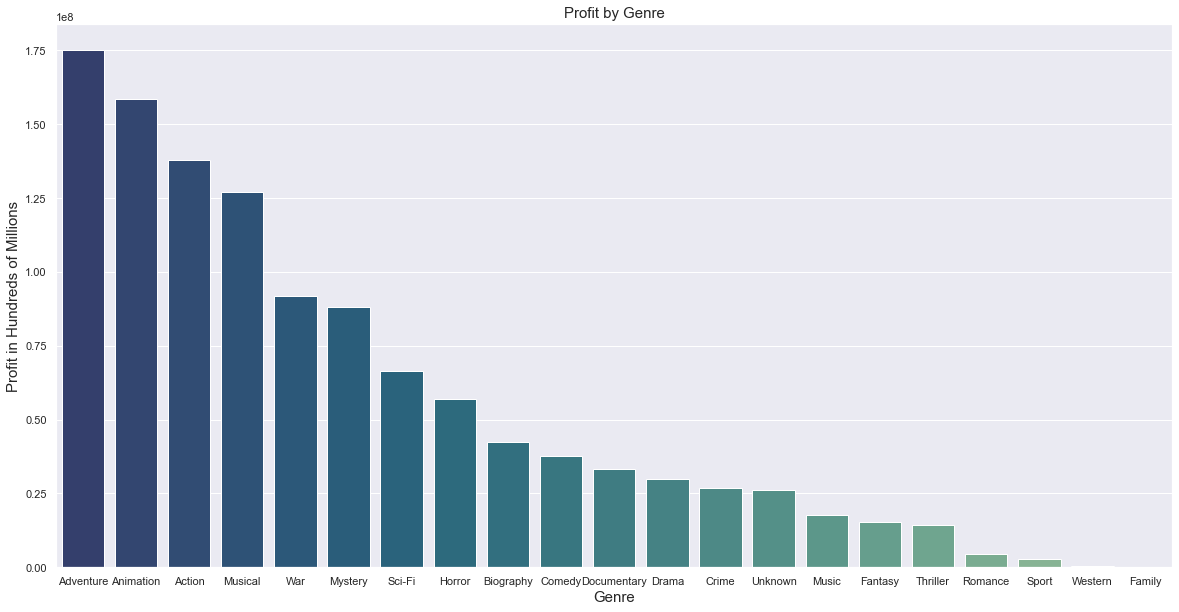

In [21]:
plt.figure(figsize=(20,10))
result = g_vis.groupby(["genres"])['profit'].aggregate(np.mean).reset_index().sort_values('profit',ascending=False)
sns.barplot(data=g_vis, x= 'genres', y = 'profit', ci=None, palette='crest_r', order=result['genres'])
plt.title("Profit by Genre", fontdict={'fontsize': 15})
plt.xlabel("Genre", fontdict={'fontsize': 15})
plt.ylabel("Profit in Hundreds of Millions", fontdict={'fontsize': 15})

Our graph shows us that the mean profits for the adventure, animation, and action genres are the highest while those for the sport, western, and family genres produce almost no profits. We can now use this data to perform a hypothetical test.

# Hypothetical Test: One-Sample T-Test

First we need to establish our Null and Alternative Hypotheses:<br>
> Ho: There is no significant relationship between the genre and expected profits of a movie.<br>
> Ha: There is a signficant relationship between the genre and expected profits of a movie.<br>

Now that we have established our Null and Alternative Hypotheses, we can create a function for calculating the p-value & t-critical value using a One-Sample T-Test. This function will accept a sample list, population mean variable, and confidence level.<br>
>Our sample list will be a list of all the profits for each genre.<br>
Our population mean variable will be equal to the mean of all profits of all entries in the table.<br>
Our confidence level will be 95%, therefore our alpha value for the function will be 0.05.

### Function for One-Sample T-Test

In [22]:
def one_sample_ttest(sample, popmean, alpha):

    # Visualize sample distribution for normality 
    sns.distplot(sample)
    
    # Population mean 
    mu = popmean
    # Sample mean (x̄) using NumPy mean()
    x_bar = sample.mean()
    # Sample Standard Deviation (sigma) using Numpy
    sigma = np.std(sample)
    # Degrees of freedom
    df = len(sample)-1
    # Calculate the critical t-value
    t_crit = stats.t.ppf(1-alpha, df=df)
    # Calculate the t-value and p-value      
    results = stats.ttest_1samp(a=sample, popmean=mu)
    # return results
    return (results, t_crit)

Now that our function is established, we need to convert our data to make it usable in the function.<br>
First, we will establish the popmean and alpha variable that are accepted by the T-test function.<br>
### Establishing popmean and alpha variables

In [23]:
popmean = g_vis['profit'].mean()
alpha = 0.05

Now we will run our T-test using the most profitable column as seen by our visualization, the Adventure genre.<br>
In order to do so, we need to convert all the profits of adventure movies from our DataFrame into a list.
### Finding all adventure genre movies and taking their profits and creating a list

In [24]:
adventure_profit = g_vis.loc[g_vis['genres'] == 'Adventure']
adventure = adventure_profit['profit'].array
print(adventure)

<PandasArray>
[  33351496,   29119358,   29174545,   -1000000,   -1011249,   30401882,
  196392649,  825491110,  -15686698,  487517365,
 ...
   71306500,   52148538,   99710550,   96861183, 2008208395,  151896578,
  140361578,  124806430,   51455875,  -49800000]
Length: 200, dtype: int64


Now that we have all the necessary data in their respective formats, we can call the T-test function and find our values.
### Conducting One-Sample T-Test: Adventure genre

C:\Users\ztillery\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(Ttest_1sampResult(statistic=5.150200844905634, pvalue=6.235922563699359e-07),
 1.652546746165939)

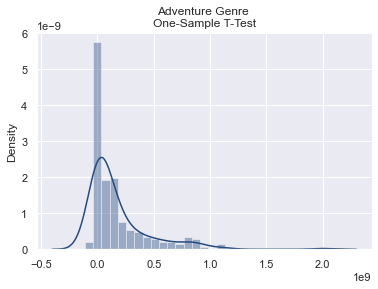

In [25]:
plt.title("Adventure Genre \nOne-Sample T-Test")
one_sample_ttest(adventure, popmean, alpha)

We an see from our p-value that we obtained a significantly small value that is considerably less than our confidence level of 0.05. Therefore, we can reject the null hypothesis and state that the Adventure genre category has a signicant relationship to the mean profits expected.<br>
Now let's do the same test and process with the second most profitable category: Animation <br>
### Conducting One-Sample T-Test: Animation genre

In [26]:
animation_profit = g_vis.loc[g_vis['genres'] == 'Animation']
animation = animation_profit['profit'].array
print(animation)

<PandasArray>
[389500298, 474464573, 787854547, -20000000,  -5000000, 228648063, -13318189,
 -29689015, 293505812,  42150788,  -2293832,   3414530,  -7146713,  16277770,
 183437486, 161502246,  -1500000, 222831065, -22493812, 559454789,  67292062]
Length: 21, dtype: int64


C:\Users\ztillery\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(Ttest_1sampResult(statistic=1.7202204134764614, pvalue=0.10082938682548488),
 1.7247182429207857)

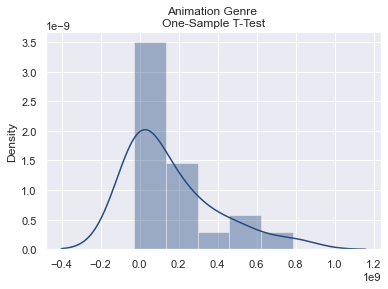

In [27]:
plt.title("Animation Genre \nOne-Sample T-Test")
one_sample_ttest(animation, popmean, alpha)

We an see from our p-value that we obtained a value that is greater than our confidence level of 0.05. Therefore, we can accept the null hypothesis for the animation genre, reasoning that there is no relationship between the animation genre and expected mean profits.

In [28]:
print('Test')

Test
